# Practica 6

En esta práctica entrenaremos un nuevo clasificador de audio. En la práctica 5
diseñamos un total de 85 características a partir del espectrograma. En esta práctica
dejaremos que sea la red neuronal la que aprenda directamente a extraer estas características
a partir del espectrograma mel. 

Comenzaremos por las funciones necesarias para preprocesar los audios. Esto es, pasar
de las muestras originales al espectrograma mel. 


## Preprocesado de audio

El preprocesado de audio debe obtener el espectrograma de cada audio a partir de las muestras


In [7]:
import torch
from torch import nn
import librosa
import numpy as np
from utils import nextpow2
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from utils import detect_speech
import pytest

La función siguiente debe extraer el espectrograma a partir de un fichero de audio. Los pasos serán los siguientes:

1.  Cargar el fichero wav
2.  Recortar los silencios iniciales y finales con `detect_speech`
3.   Si la duracion del audio recortado es menor que 1.1 segundos. Añadiremos ceros al final hasta completar esa longitud. El objetivo es que el todos los audios preprocesados tengan la misma duración. En caso de que la duración del audio recortado sea mayor que 1.1 segundos recortaremos el audio quedandonos con los primeros 1.1 segundos.
4.    Calculo del espectrograma mel con los parametros indicados en la función



In [8]:
def linear_normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val + 1e-10)
    return normalized_array


def preprocess_audio(filename):

    # Cargamos audio y recortamos silencios
    audio_data = None
    sample_rate = None
    vad = None
    # BEGIN_SOLUTION

    audio_data, sample_rate = librosa.load(filename, sr=None)
    vad = detect_speech(audio_data, sample_rate)

    # if len(vad) < len(audio_data):
    #     vad = np.pad(vad, (0, len(audio_data) - len(vad)),
    #                  'constant')  # rellenamos con ceros

    # print(len(vad), len(audio_data))
    # print(np.shape(vad), np.shape(audio_data))

    # END SOLUTION

    if len(vad) < 0.1 * sample_rate:  # detect speech no ha ido bien, descartamos audio
        return None

    target_duration = 1.1  # para que todos los audios duren lo mismo
    target_length = int(target_duration * sample_rate)
    # si la duracion es mayor que target length recortamos y si es menor rellenamos con ceros
    # Dejar el resultado en la variable audio
    audio = vad  # dejar el resultado en esta variable
    # BEGIN SOLUTION

    # ajustamos el vad y el audio_data a la misma longitud y misma posicion
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')

    if len(audio_data) > target_length:
        audio_data = audio_data[:target_length]
    else:
        audio_data = np.pad(
            audio_data, (0, target_length - len(audio_data)), 'constant')

    # quita todos los ceros a principio de la señal de audio
    idx = 0
    while audio[idx] == 0:
        idx += 1
    audio = audio[idx:]
    audio_data = audio_data[idx:]

    # plt.figure(figsize=(10, 5))
    # plt.plot(audio_data)
    # plt.show()

    # END SOLUTION

    n_mels = 32
    frameDuration = 0.03  # 30 ms
    win_length = int(frameDuration*sample_rate)
    n_fft = 2**nextpow2(win_length)

    # Calcula el espectrograma mel con los parametros anteriores
    # BEGIN SOLUTION

    S = librosa.feature.melspectrogram(
        y=audio_data, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=int(win_length/2))

    # END SOLUTION

    # Convert to decibels (log scale)
    # S_dB = librosa.power_to_db(S+1e-6, ref=np.max)
    S_dB = np.log(S+1e-6)

    S_dB = linear_normalize(S_dB)  # Ajusta las amplitudes entre [0-1]

    return S_dB

(32, 27)


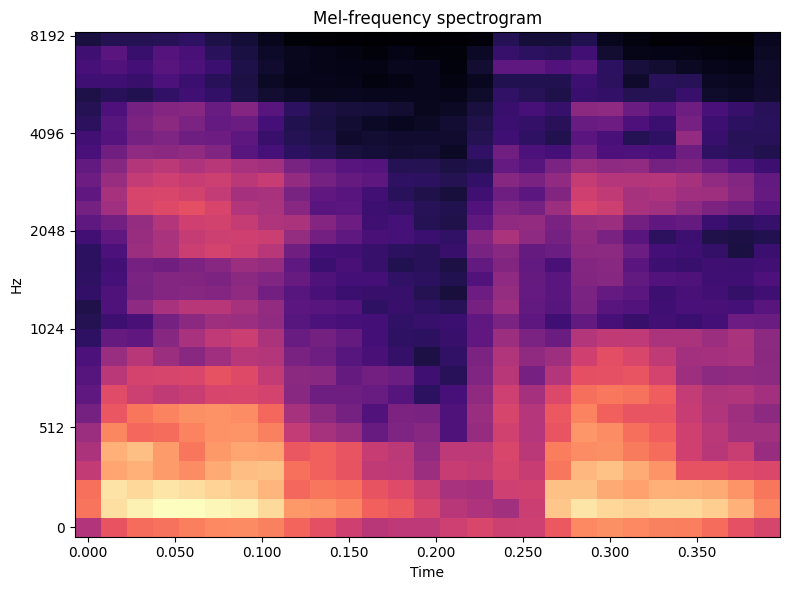

In [9]:
# Comprobación
S_dB = preprocess_audio('siete.wav')
# S_dB = preprocess_audio('/srv/data/audios/base_datos_numeros/train/seis/2023_008_AB_seis_4_1.wav')
# assert S_dB.shape == (32,28), "comprueba como calculas el espectrograma mel"
# assert S_dB[10,10]==pytest.approx(0.30, abs=1e-2)

print(S_dB.shape)

# Plot the Mel spectrogram
sample_rate = 16000
plt.figure(figsize=(8, 6))
librosa.display.specshow(S_dB, sr=sample_rate,
                         hop_length=240, x_axis='time', y_axis='mel')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()

## Create dataset

Ahora crearemos los datasets para realizar el entrenamiento de la red neuronal. 

En primer lugar vamos a 
preprocesar todos los audios de la base de datos. Obteniendo como resultado 
dos tensores con todas las imagenes de train y validacion respectivamente. 



In [10]:
# localizacion de los wav
audios_train = '/Users/oscarjimenezbou/Documents/University_projects/TDS/P6/base_datos_numeros_2023_AB/train'
audios_valid = '/Users/oscarjimenezbou/Documents/University_projects/TDS/P6/base_datos_numeros_2023_AB/test'

# las etiquetas son el nombre de la carpeta
map_labels = {'cero': 0,
              'uno': 1,
              'dos': 2,
              'tres': 3,
              'cuatro': 4,
              'cinco': 5,
              'seis': 6,
              'siete': 7,
              'ocho': 8,
              'nueve': 9}

Para crear los datasets vamos a emplear la funcion `create_dataset`. Los pasos que realiza son:
1. Crea una lista con todos los ficheros wav
2. Los guarda en una tabla de pandas (parecido a una hoja excel)
3. Crea columna `label`, a partir del nombre de la carpeta de cada audio
4. Convierte `label` a un entero con el diccionario `map_labels`.
5. Para cada fichero extrae el espectrograma con la funcion `preprocess_audio`.
6. Crea un tensor con los espectrogramas y un tensor con las etiquetas
7. Con la clase `TensorDataset` de Pytorch crea el dataset.

In [11]:

def create_dataset(audios_folder):
    audio_files = pathlib.Path(audios_folder).rglob('*.wav')
    df = pd.DataFrame({'filename': list(audio_files)})
    df['label'] = df.filename.apply(lambda x: str(x).split('/')[-2])
    df['y'] = df.label.map(map_labels)
    print("Number of  images  in dataset= ", len(df))
    # print(df.head())

    all_specgrams = []
    all_labels = []

    num_audios = len(df)

    for k in tqdm(range(num_audios)):
        row = df.iloc[k]
        features_v = preprocess_audio(row['filename'])
        if features_v is None:
            continue

        if features_v.shape[1] < 10:
            print("bad audio ", row['filename'])
            continue
        all_labels.append(row['y'])
        all_specgrams.append(features_v[np.newaxis, :, :])
        # if k > 10:
        #    break
    all_specgrams = np.array(all_specgrams)
    all_labels = np.array(all_labels)

    X_tensor = torch.tensor(all_specgrams, dtype=torch.float32)
    Y_tensor = torch.tensor(all_labels, dtype=torch.long)

    # Create TensorDataset
    dataset = TensorDataset(X_tensor, Y_tensor)

    return dataset

In [12]:
# creamos tanto el dataset de train como el de validacion

train_dataset = create_dataset(audios_train)
val_dataset = create_dataset(audios_valid)

Number of  images  in dataset=  12812


  0%|          | 44/12812 [00:00<00:28, 446.62it/s]


IndexError: index 17600 is out of bounds for axis 0 with size 17600

Antes de continuar es conveniente visualizar algunos ejemplos del datast para ver que todo es correcto

ValueError: high <= 0

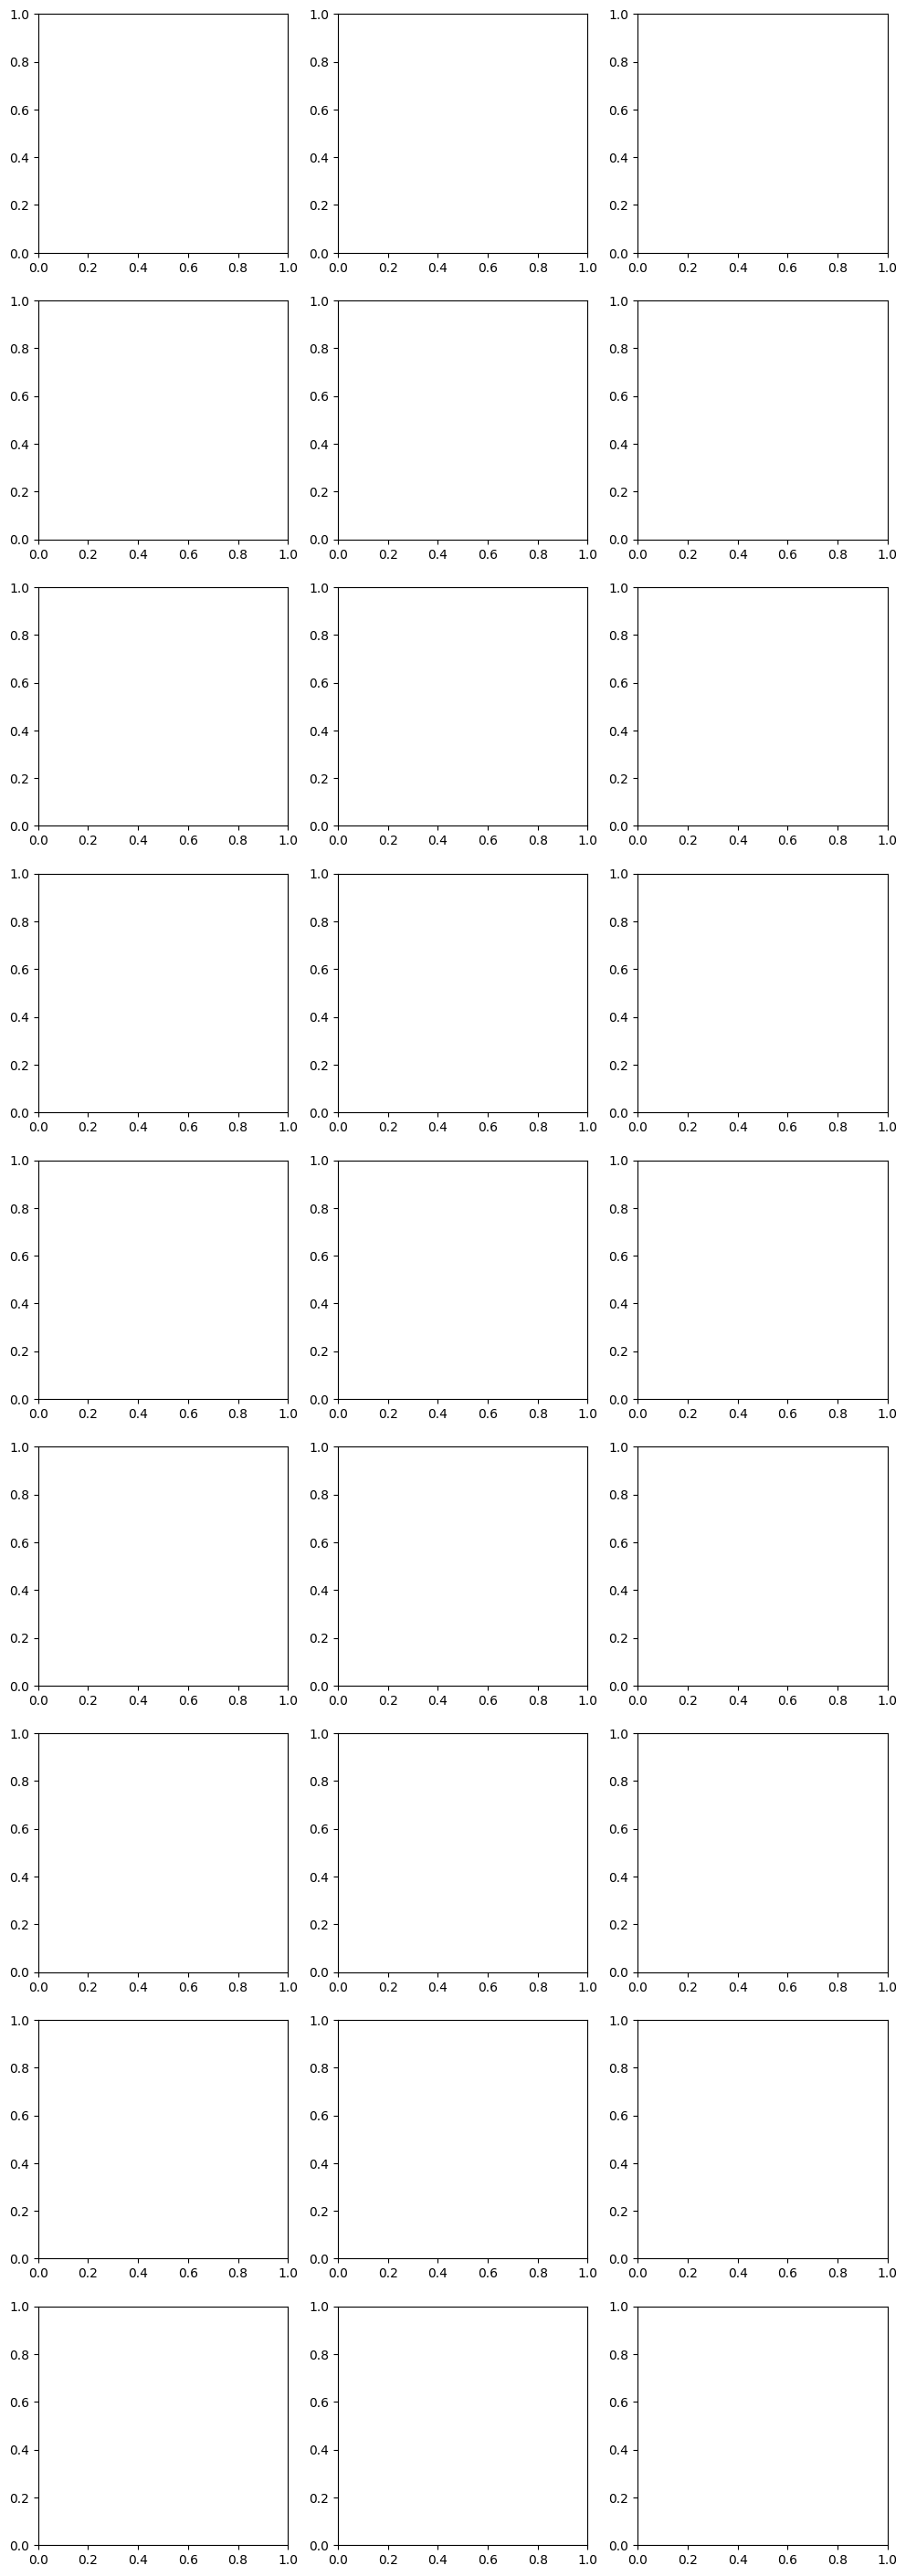

In [ ]:
def show_samples(dataset, nrows=9, ncols=3):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    axl = ax.flatten()

    num_samples = len(train_dataset)
    for k in range(len(axl)):
        sample_idx = np.random.randint(0, num_samples)
        spec, label = dataset[sample_idx]
        librosa.display.specshow(spec[0].numpy(
        ), sr=16000, hop_length=240, x_axis='time', y_axis='mel', ax=axl[k])
        # axl[k].imshow(spec[0])
        axl[k].set_title(f"label {label}")
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


show_samples(train_dataset)

## Network

En este apartado definiremos la red neuronal convolucional. Al igual que en la practica 5, nos definiremos un modulo auxiliar 
que se repite varias veces en la red en concreto el módulo `conv_layer`. Debe añadir los siguientes elementos:
* `nn.Conv2d`: Convolucion 2d, kernel de tamaño 3 y padding =1
* `nn.BatchNorm2d`: Similar al batch norm para el caso de imagenes
* `nn.ReLU`: No linealidad

Como verá en el codigo de abajo, opcionalmente este modulo tambien puede realizar max pooling.


In [ ]:
from torch import nn


class conv_layer(nn.Sequential):
    def __init__(self, input_feat, out_feat, max_pool=True):
        layers = []
        # Complete con vonv2d, batchnorm2d y relu añadiendo a la lista: layers.append(...)

        # BEGIN SOLUTION
        layers.append(nn.Conv2d(input_feat, out_feat,
                      kernel_size=3, stride=1, padding=1))
        layers.append(nn.BatchNorm2d(out_feat))
        layers.append(nn.ReLU(inplace=True))
        # END SOLUTION

        if max_pool:
            layers.append(nn.MaxPool2d(3, 2, padding=1))
        super().__init__(*layers)

In [ ]:
# Comprobacion

l = conv_layer(1, 16)

elems = list(l.children())
assert isinstance(elems[0], nn.Conv2d), "primero conv2d"
assert isinstance(elems[1], nn.BatchNorm2d), "primero conv2d"
assert isinstance(elems[2], nn.ReLU), "primero conv2d"
assert elems[0].in_channels == 1, "nuermo de canales de entrada mal"
assert elems[0].out_channels == 16, "nuermo de canales de entrada mal"

In [ ]:
# Modulo final antes de la salida, no tiene parametros por tanto no hace falta init
class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

Ahora crearemos la red convolucional con los modulos anteriores, a estructura es la siguiente (tomaremos numF=16):
* Capa1, conv_layer input_channels->numF, con maxpool
* Capa2, conv_layer numF -> 2* numF, con maxpool
* Capa3, conv_layer 2*numF -> 4* numF, con maxpool
* Capa4, conv_layer 4*numF -> 4* numF, **sin** maxpool
* Capa5, conv_layer 4*numF -> 4* numF, **sin** maxpool
* Maxpool temporal (se proporciona)
* Dropout (se proporciona)
* Flatten (se proporciona)
* Lineal de salida (se proporciona)




In [ ]:


class MyNet(nn.Sequential):
    def __init__(self, dropoutProb=0.2, num_classes=10):
        input_channels = 1
        numF = 16
        # Tamaño del último maxPooling. Hace que la última capa solo tenga 1
        # neurona en la dimensión temporal
        timePoolSize = int(np.ceil(74/8))

        layers = []
        # añada las capas que se le indica en el texto
        # BEGIN SOLUTION

        layers.append(conv_layer(input_channels, numF))
        layers.append(conv_layer(numF, numF, max_pool=False))
        layers.append(conv_layer(numF, 2*numF))
        layers.append(conv_layer(2*numF, 2*numF, max_pool=False))
        layers.append(conv_layer(2*numF, 4*numF))
        layers.append(conv_layer(4*numF, 4*numF, max_pool=False))
        layers.append(conv_layer(4*numF, 8*numF))
        layers.append(conv_layer(8*numF, 8*numF, max_pool=False))
        # END SOLUTION

        layers.append(nn.MaxPool2d((1, timePoolSize)))
        layers.append(nn.Dropout2d(dropoutProb))
        layers.append(Flatten())
        layers.append(nn.Linear(64*4, num_classes))  # obtiene los logits

        super().__init__(*layers)

In [ ]:
X_test = torch.randn(1, 1, 32, 74)
net = MyNet()
y = net(X_test)
assert y.shape == (1, 10), "tendremos una salida"
assert len(list(net.modules())) == 28, "revise la estructura de la red"
assert sum([len(p) for p in net.parameters()]
           ) == 980, "revise la estructura de la red"

RuntimeError: Given input size: (128x2x5). Calculated output size: (128x2x0). Output size is too small

## Training Loop

Una vez definida la red la parte de entrenamiento es exactamente igual que la de la practica 5. 

En el caso de las redes convolucionales la GPU si está disponible supone una gran diferencia para entrenar los modelos. 

Comente la linea 'cpu' o 'cuda' y compruebe la diferencia abismal entre los tiempos de ejecución:

In [ ]:
from train_net import train
import torch.optim as optim
import time

# device = 'cpu'
device = 'cuda'

# Define learning rate
learning_rate = 0.001
batch_size = 512

# Define network
red = MyNet()

# Create Adam optimizer
# optimizer = optim.SGD(red.parameters(), lr=learning_rate, momentum =0.9)
optimizer = optim.Adam(red.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


num_epochs = 30
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
train_losses, val_losses, train_acc, val_acc = train(red,
                                                     loss_fn,
                                                     train_dataloader, val_dataloader,
                                                     optimizer, num_epochs, device=device)

print(f"Train finished in {time.time() - start_time} seconds")


fig, axes = plt.subplots(2, 1)
axes[0].plot(train_losses, label='train loss')
axes[0].plot(val_losses, label='val_loss')
axes[0].legend()
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(train_acc, label='train_acc')
axes[1].plot(val_acc, label='val acc')
axes[1].legend()
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('Accuracy')

ValueError: num_samples should be a positive integer value, but got num_samples=0

## Prueba con grabación

Tomaremos el modelo del apartado anterior para hacer nuestras pruebas con audios grabados
al instante.



In [ ]:
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio
import librosa

import matplotlib.pyplot as plt

* Ejecuta la siguiente celda.
* Pulsa circulo negro para comenzar a grabar.
* Di un numero
* Pulsa de nuevo para terminar la grabacion

In [ ]:
camera = CameraStream(constraints={'audio': True, 'video': False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
# convertimos a wav
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -ar 16000 -f wav file.wav  -y -hide_banner -loglevel panic

In [ ]:
# Escucha para comprobar que todo sigue ok
Audio('file.wav')

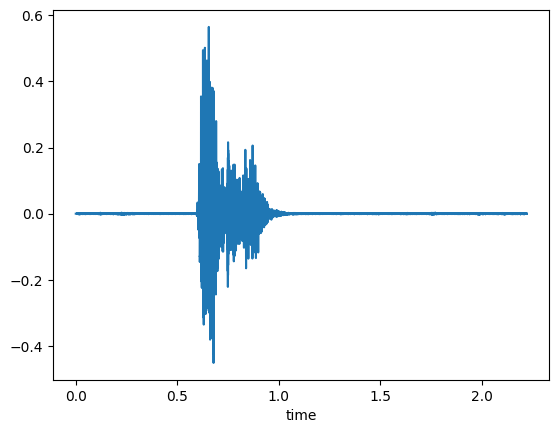

In [ ]:
# Pintamos para ver el aspecto de la señal  que no sature
audio_data, fs = librosa.load('file.wav', sr=None)
t = np.arange(len(audio_data))/fs
plt.plot(t, audio_data)
_ = plt.xlabel('time')

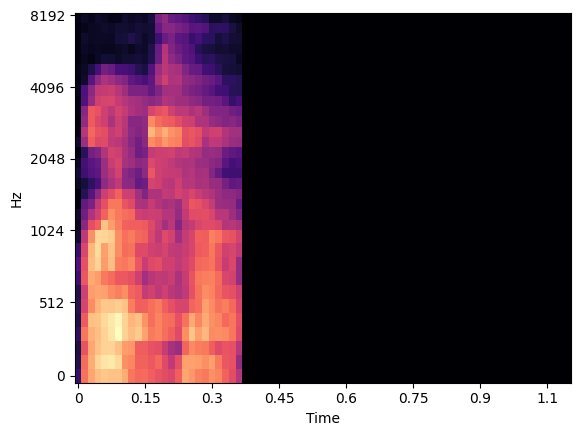

In [ ]:
S = preprocess_audio('file.wav')

librosa.display.specshow(S, sr=16000, hop_length=240,
                         x_axis='time', y_axis='mel')

In [ ]:
red.eval()

x = torch.from_numpy(S.astype(np.float32))
# añadimos dimensiones para poder hacer la inferencia
x = x.unsqueeze(0).unsqueeze(0)
x = x.to(device)
y = red(x)
print("Has dicho: ", torch.argmax(y).item())  # clasificamos con el máximo

Has dicho:  8
